In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
import platform

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *

In [3]:
data_id = 1 if platform.node()=="dg-MS-7917" else (1 if platform.node()=="doga-yg" else 0)
gpx_obj, segment = step_01_load_data(data_id)

/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11238879870.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx
Loading file: /home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11238879870.gpx
num of tracks=1


### Let's try to correct some unrealistic things like

In [4]:
segment.get_uphill_downhill()

UphillDownhill(uphill=219.77999954223637, downhill=226.77999954223657)

### ... and speed records on a bikecycle

In [5]:
speed_dict = {}
step_02_initial_speed(gpx_obj, segment, speed_dict)

none_indices = [513 514]


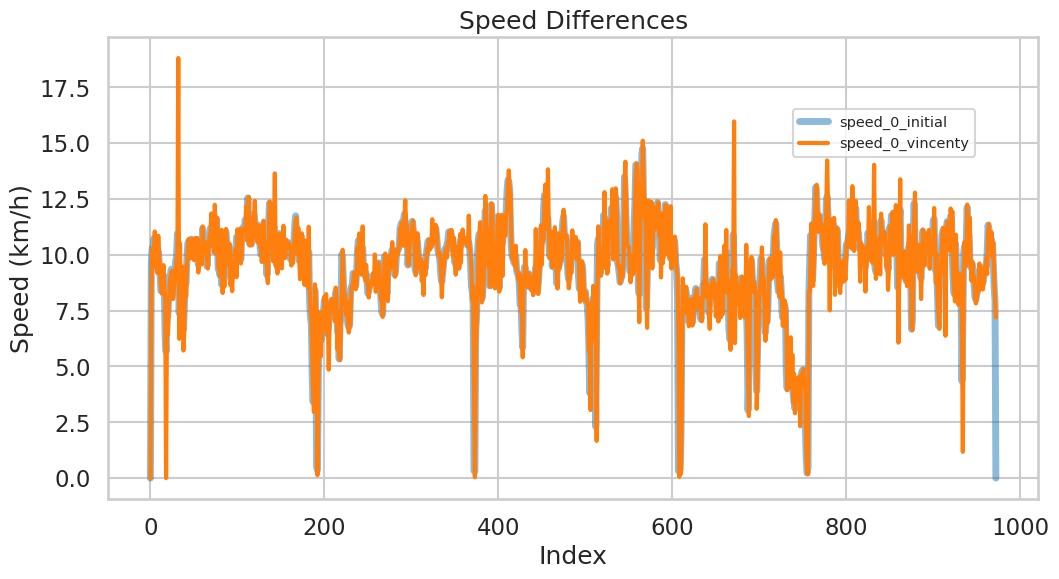

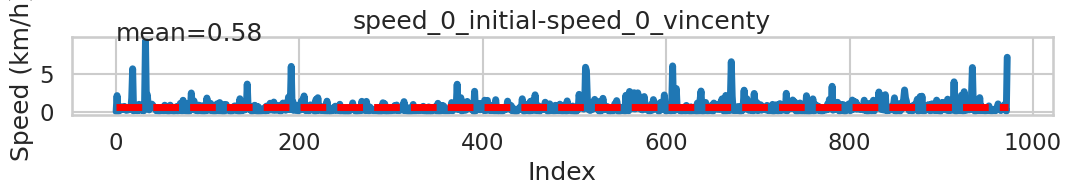

In [6]:
plot_all_keys(speed_dict)
plot_all_key_difs(speed_dict)

### But we start with a little bit of data wrangling

In [7]:
coords = step_03_segments_to_coords_pd(segment)
print(coords.head())
print(coords.tail())

                           idx        lat        lon         ele     speed
time                                                                      
2023-05-31 14:14:07+00:00    0  41.139196  29.030085  105.599998  0.000000
2023-05-31 14:14:08+00:00    1  41.139183  29.030103  105.400002  2.661331
2023-05-31 14:14:11+00:00    2  41.139159  29.030200  105.400002  2.857180
2023-05-31 14:14:12+00:00    3  41.139154  29.030233  105.400002  2.857827
2023-05-31 14:14:14+00:00    4  41.139138  29.030298  105.400002  2.981343
                           idx        lat        lon        ele     speed
time                                                                     
2023-05-31 15:24:02+00:00  968  41.138918  29.029771  97.000000  2.893867
2023-05-31 15:24:06+00:00  969  41.138997  29.029678  97.000000  2.670171
2023-05-31 15:24:13+00:00  970  41.139127  29.029558  97.199997  2.374240
2023-05-31 15:24:20+00:00  971  41.139252  29.029477  98.599998  2.198861
2023-05-31 15:24:21+00:00  972 

### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [8]:
step_04_round_time(coords)
coords.tail()

,idx,lat,lon,ele,speed
time,,,,,
2023-05-31 15:24:02,968,41.138918,29.029771,97.000000,2.893867
2023-05-31 15:24:06,969,41.138997,29.029678,97.000000,2.670171
2023-05-31 15:24:13,970,41.139127,29.029558,97.199997,2.374240
2023-05-31 15:24:20,971,41.139252,29.029477,98.599998,2.198861
2023-05-31 15:24:21,972,41.139270,29.029478,98.599998,0.000000


### Do we have signal loss?

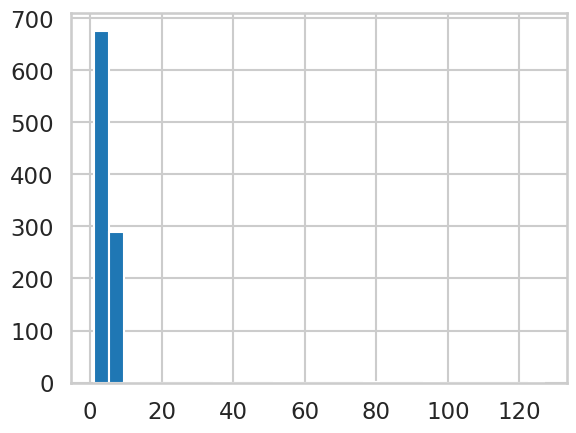

In [9]:
plt.hist(np.abs(np.diff(coords.index).astype('timedelta64[s]').astype(float)), bins=30);

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [10]:
coords = step_05_resample(coords=coords, freq='1s')

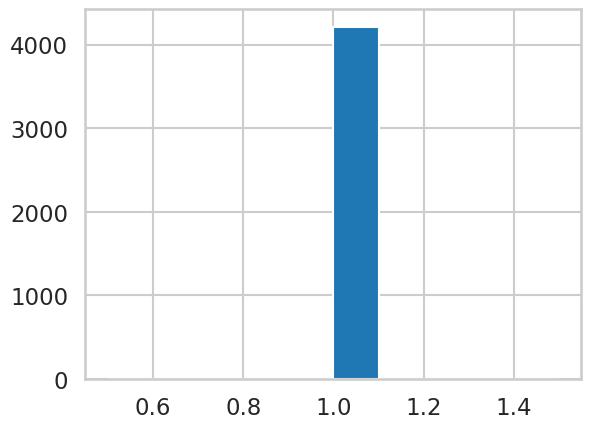

In [11]:
coords.loc[coords.ele.isnull()].head()
plt.hist(np.diff(coords.index).astype('timedelta64[s]').astype(float));

### Almost done. Now convert to good old numpy array and mask NaNs

In [12]:
measurements = step_06_get_measurements_from_coords(coords) # lon-0 lat-1 ele-2

### So where did I lose the GPS signal?

num of filled coords=3242 in 4215


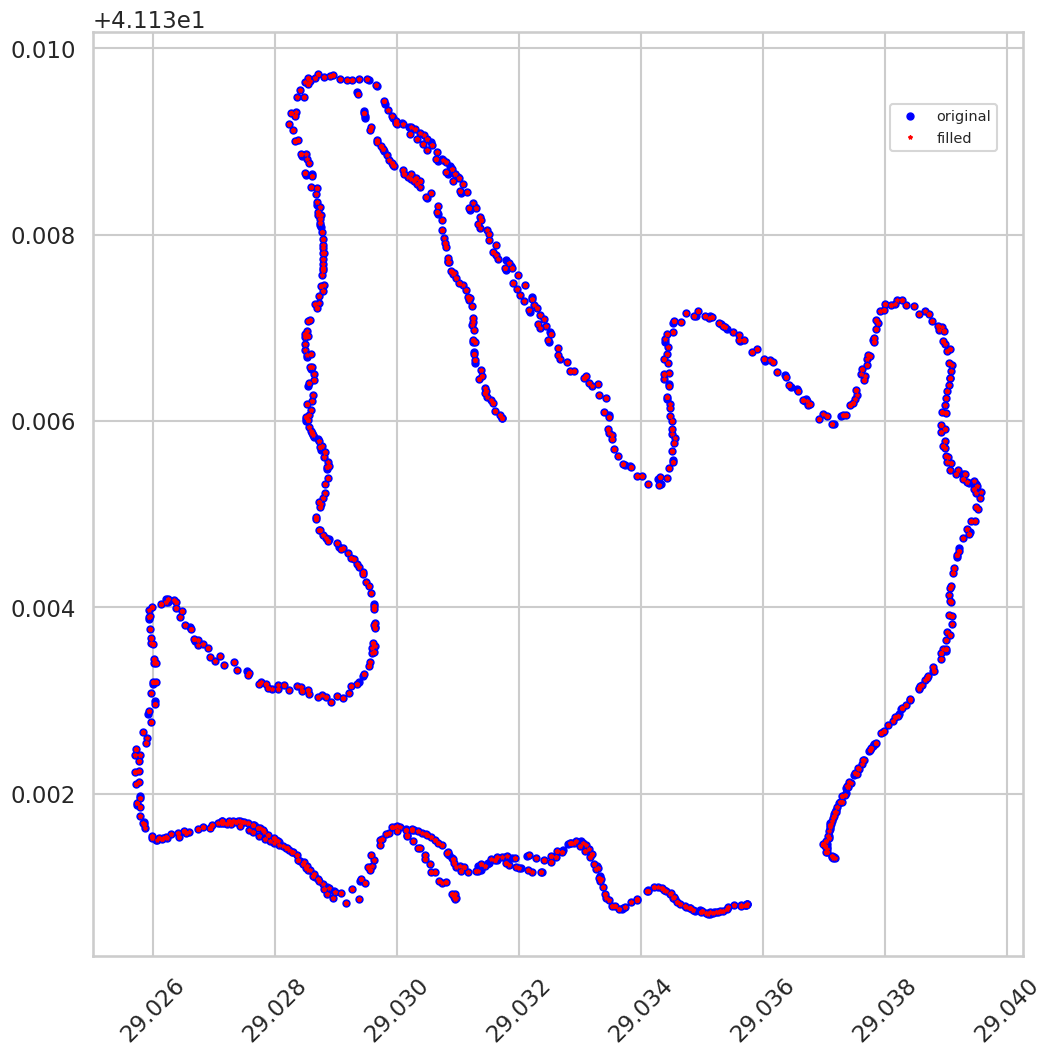

In [13]:
coords, original_coords_idx = step_07_fill_nan_values(coords, measurements, 2)

### Let's set up the Kalman Filter

In [14]:
kf, kf_dict = step_08_setup_kalman_filter(measurements)

### Compare now our measurements with a smoothed track

In [15]:
state_means, state_vars = step_09_apply_kalman(kf, measurements)

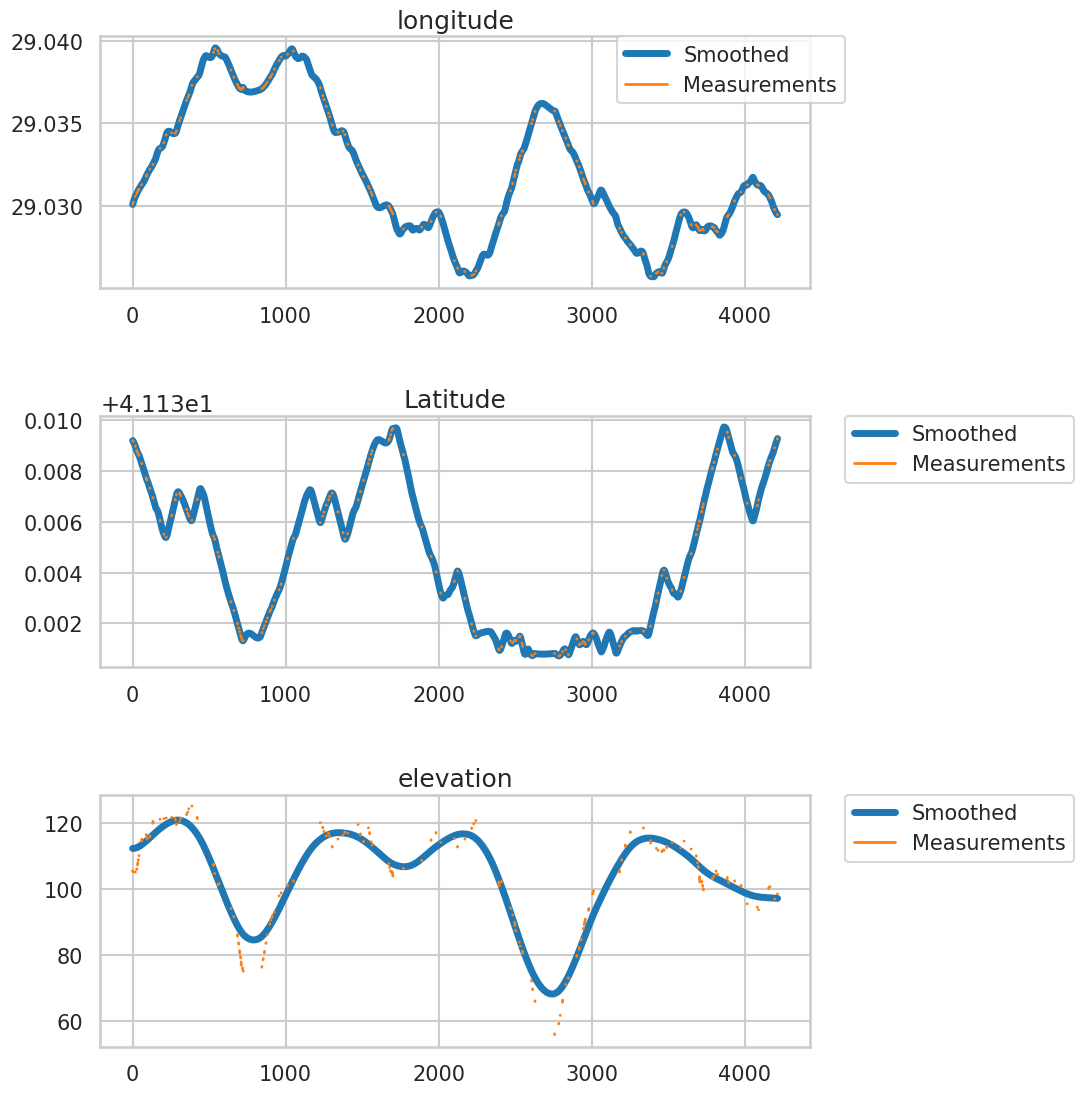

In [16]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

### Let's write the smoothed data back into our dataframe and GPX file

In [17]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [18]:
segment.get_uphill_downhill()

UphillDownhill(uphill=97.42697485524856, downhill=112.55495384734105)

### Yes, that sounds much more realistic!!! Let's also check the speed

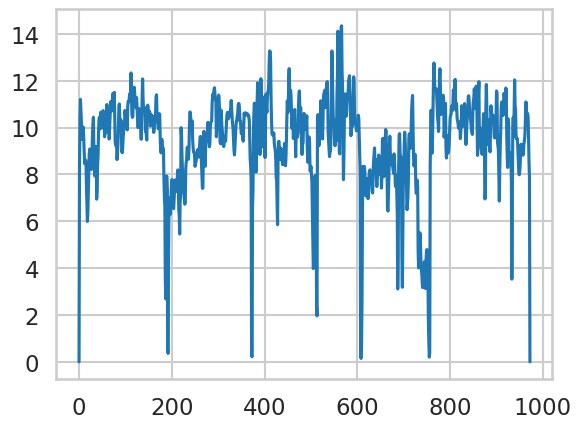

In [19]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_1_after_kalman', plot_after_add=True)

### Arrrggh!!! Still not good! What the heck is going on?

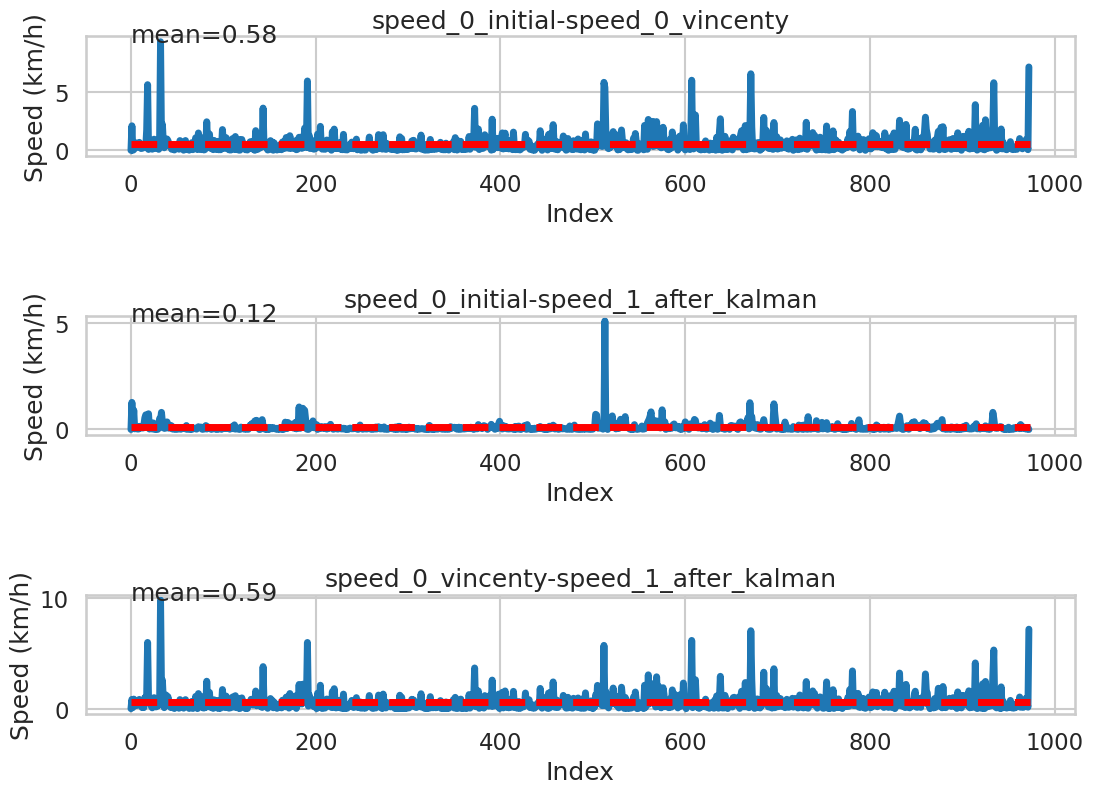

In [20]:
plot_all_key_difs(speed_dict)

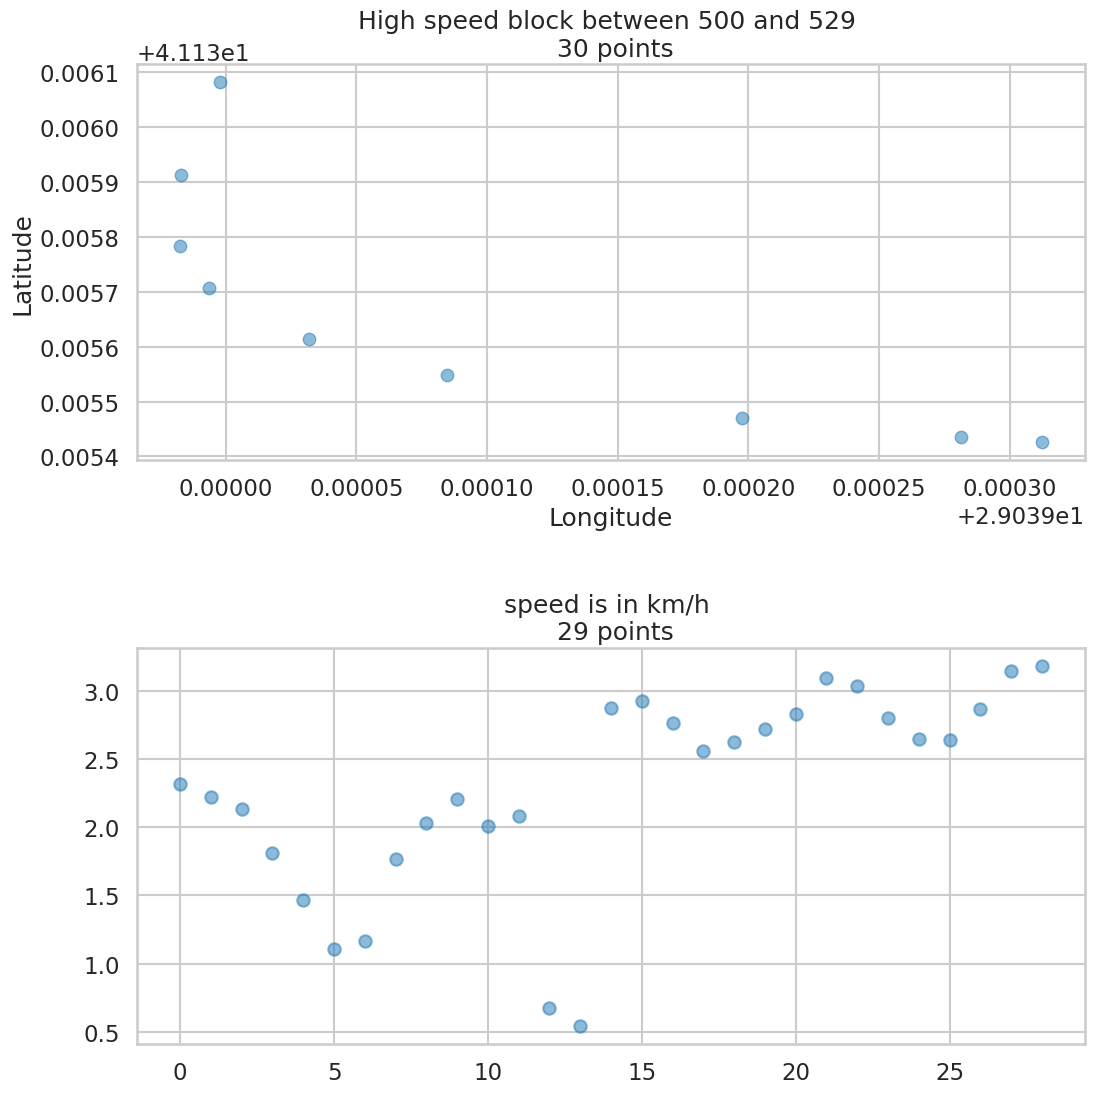

In [22]:
high_speed_block = step_13_get_high_speed_block(speed, measurements, segment, plot_result=True, verbose=False)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [23]:
measurements, bad_readings = step_14_find_bad_readings_from_variance(measurements, state_vars, verbose=True)

there are 4215 of mask vars.
number of true elements in the mask(shape=(4215, 3) with 12645 elements) are 9726
there are 29 bad readings
bad readings where the mask was false count is: 29


In [24]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [25]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

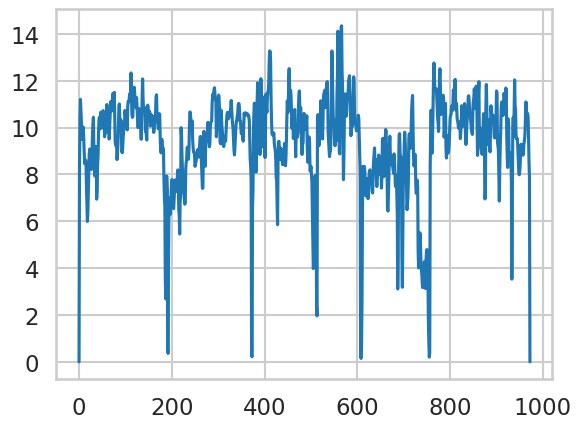

In [26]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_2_add_missing', plot_after_add=True)

### We are getting there! Let's take a look where the problem is...

there are 4215 of mask vars.
number of true elements in the mask(shape=(4215, 3) with 12645 elements) are 9726
number of masked elements=3242 unmasked=973


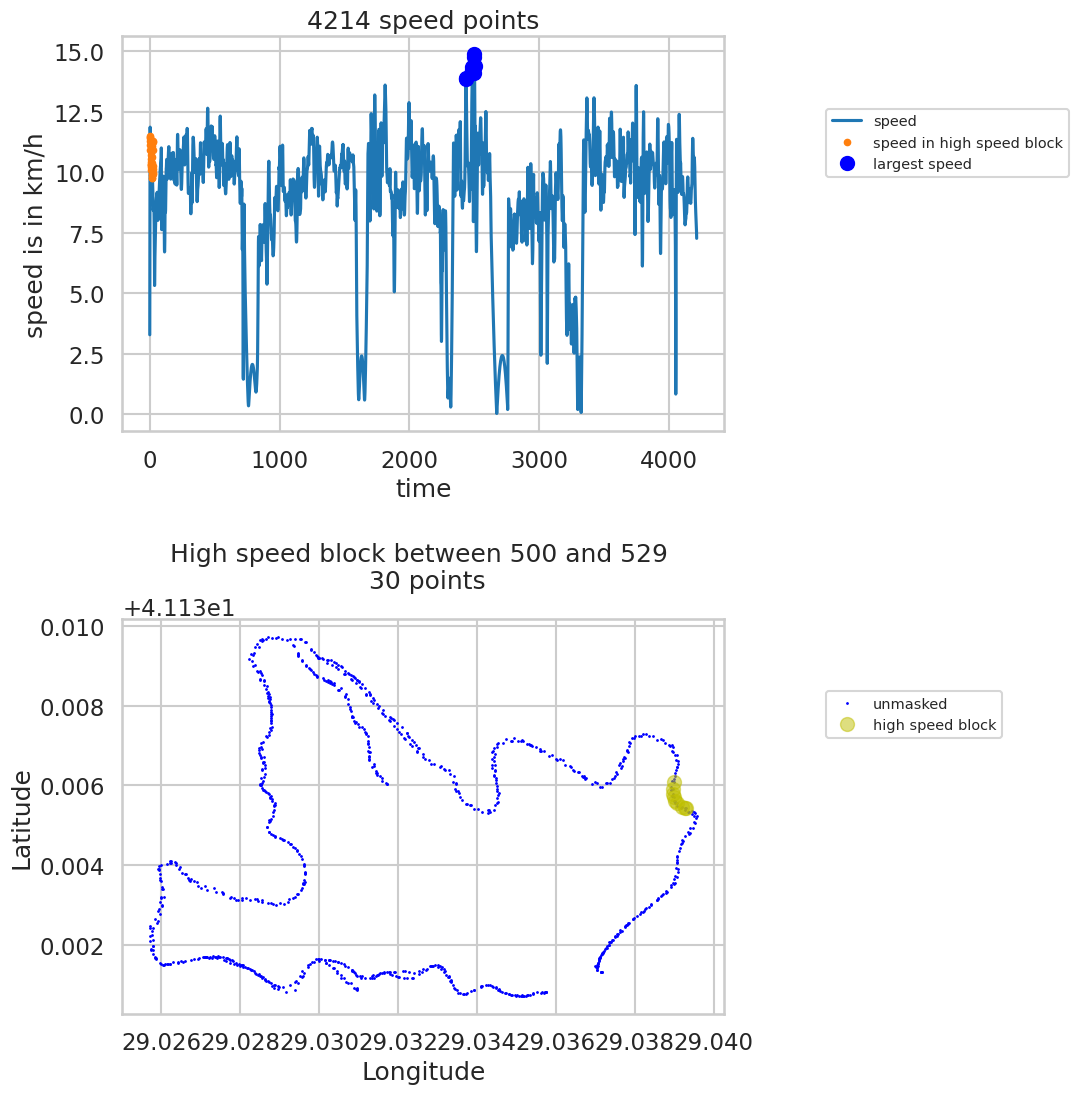

In [29]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_3_after_calc", measurements, high_speed_block, verbose=False, plot_result=2)

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

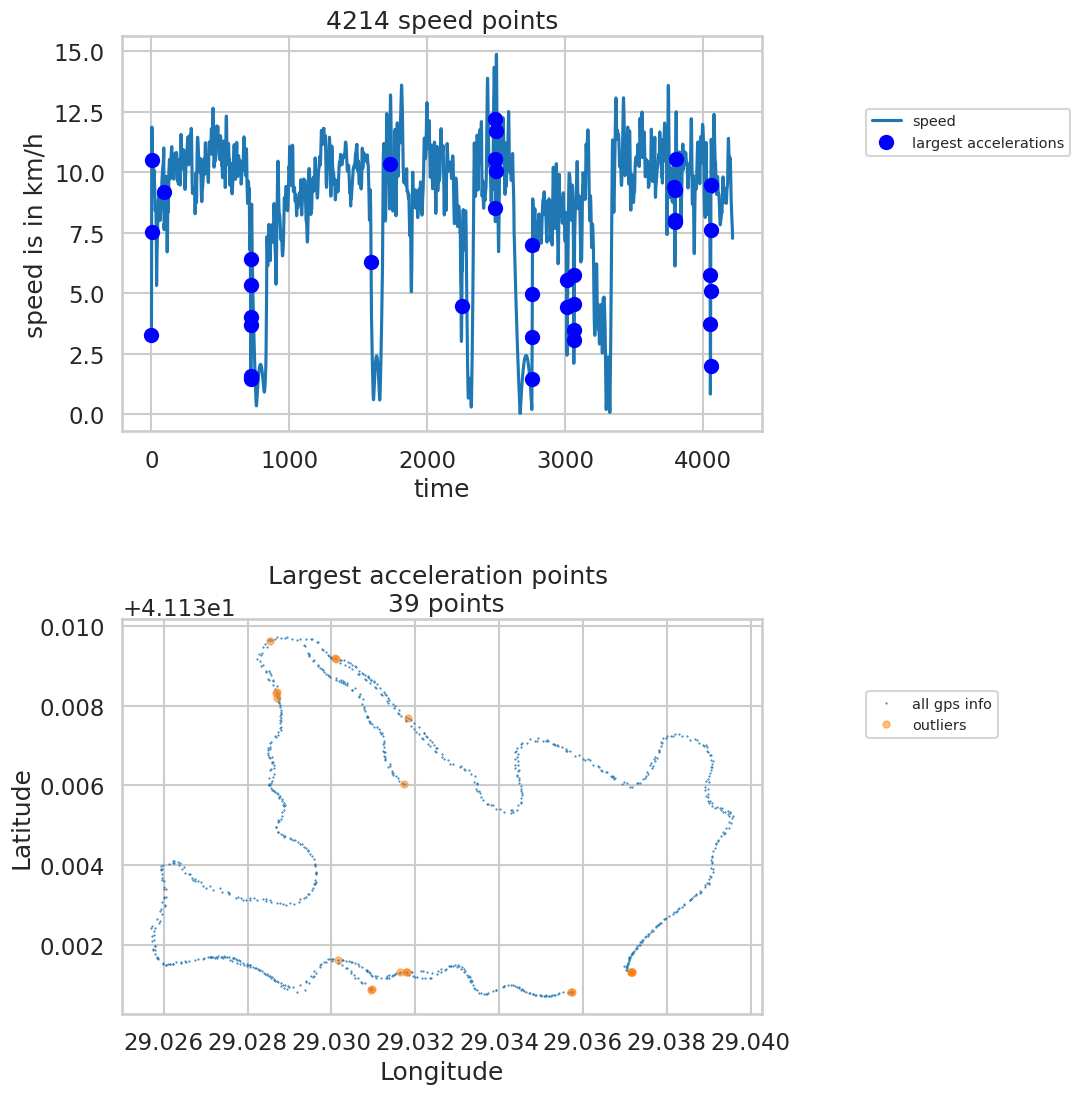

In [30]:
outliers_idx = step_18_check_for_outliers_by_strong_accelerations(speed_dict["speed_3_after_calc"], measurements, plot_result=True)

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [31]:
state_means, state_vars, measurements = step_19_mask_around_outliers(kf, measurements, outliers_idx, neighbour_cnt=12)

In [32]:
state_means, state_vars = step_20_apply_kalman(state_means, state_vars, kf, n_times=20)

Iterations in sec:<0:2.07><1:2.09><2:1.99><3:1.95><4:2.12><5:1.95><6:1.92><7:1.94><8:2.02><9:1.97><10:1.96><11:1.96><12:1.95><13:1.96><14:1.97><15:2.21><16:1.97><17:2.04><18:1.99><19:1.99>

Durations: min(1.9193789958953857), mean(2.00025053024292), max(2.206143856048584)


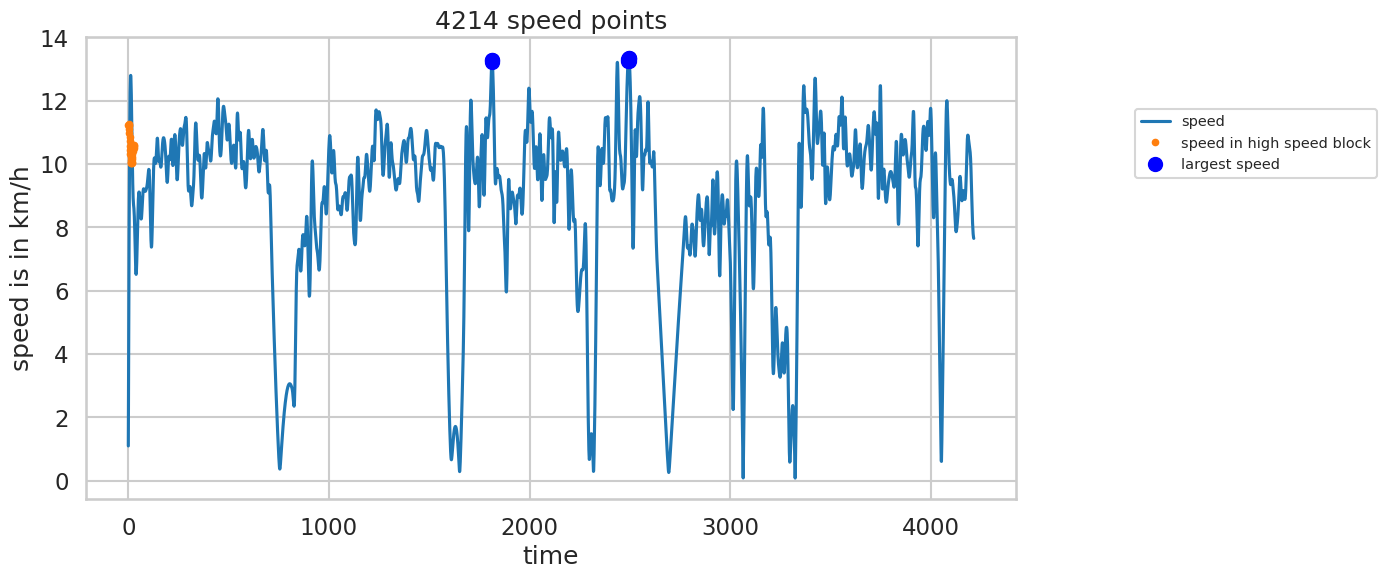

In [33]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_4_after_calc20", measurements, high_speed_block, verbose=False, plot_result=1)

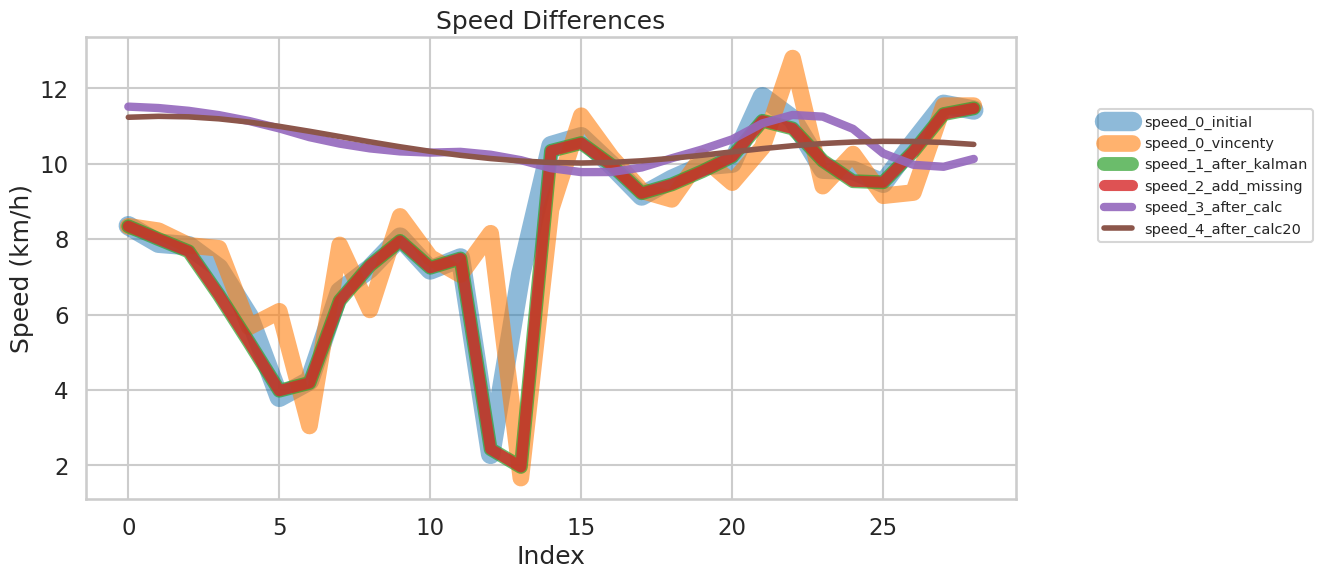

In [34]:
plot_all_keys(speed_dict,fr_to=[min(high_speed_block),max(high_speed_block)])
#plt.plot(speed_dict["speed_4_after_calc20"][min(use_sub_arr):max(use_sub_arr)], '.')

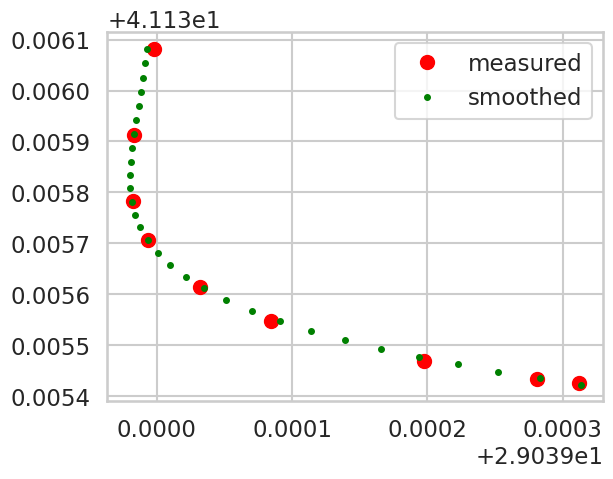

In [35]:
plt.plot(measurements[high_speed_block,0], measurements[high_speed_block,1], 'ro', label='measured', markersize=10)
plt.plot(state_means[high_speed_block,0], state_means[high_speed_block,1], 'g.',label='smoothed', markersize=8)
plt.legend()
plt.show()

In [36]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [37]:
segment.get_uphill_downhill()

UphillDownhill(uphill=53.77016185905106, downhill=74.84670120306546)

### Finally, write everything back to the GPX file

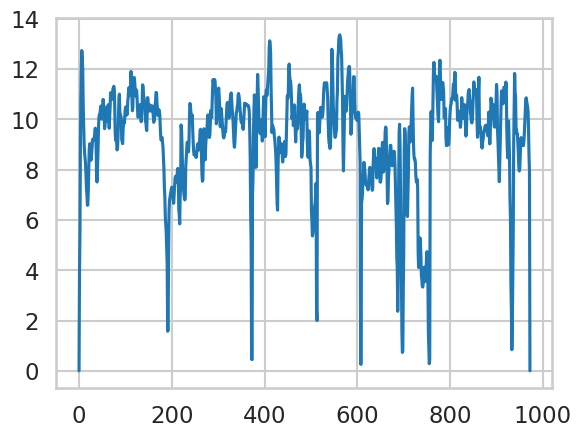

In [38]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_5_after_final', plot_after_add=True)

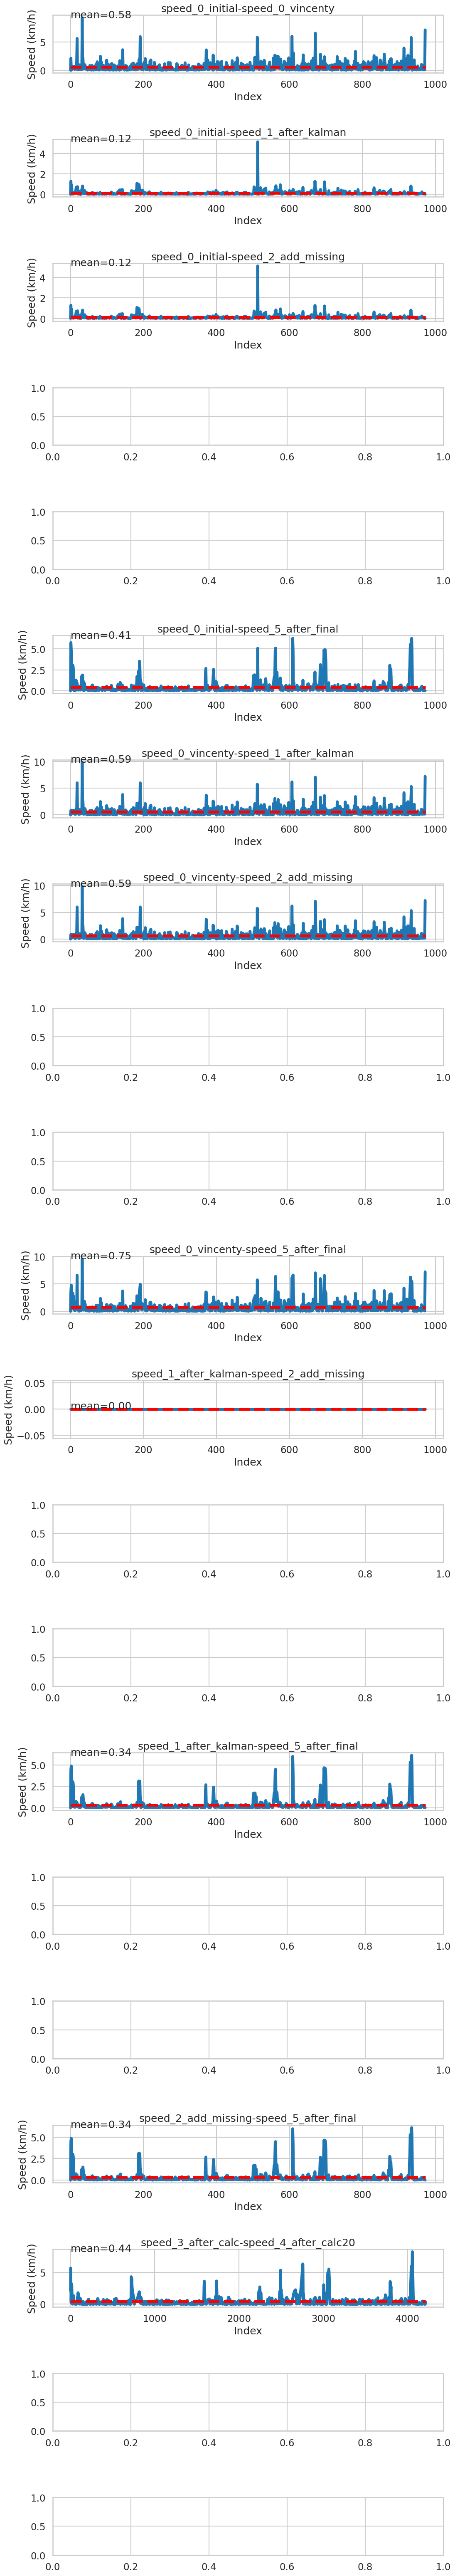

In [39]:
plot_all_key_difs(speed_dict)

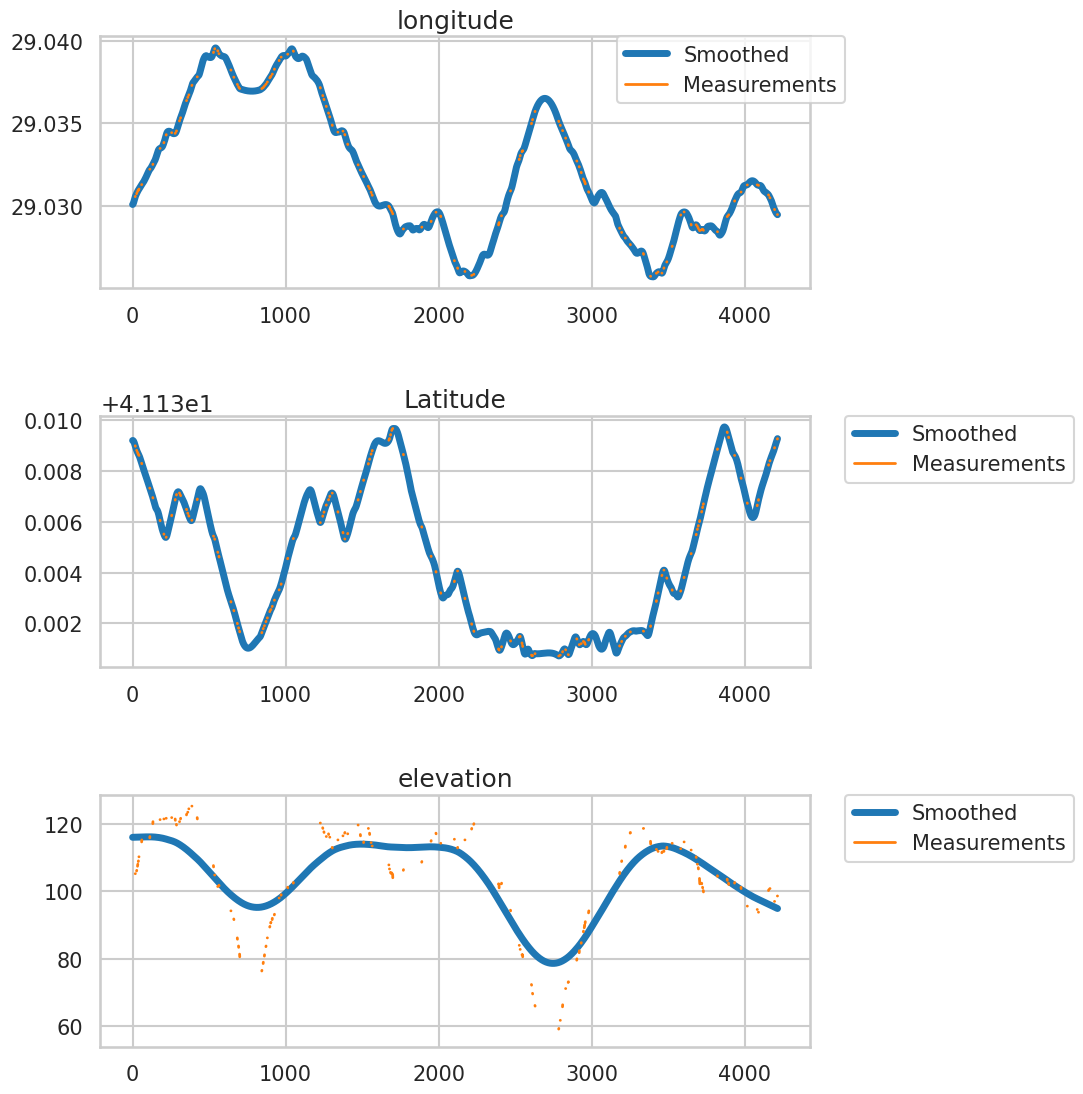

In [40]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

1- kalman filtreye girdiğinde state_means üzerinden distance toplamına odaklan\n
   ne kadar değişiyor her iiterasyonda \n
2- aynı zamanda elevation da\n
   elevation smooth ettikçe azalıyor - bir hata var o işte\n
3- bir de elevation bilgisini gps bilgisinden alma vardı. o nerede?\n
4- niye 3600 elemanlı veri var? 

In [ ]:
#with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
#    fh.write(gpx_file.to_xml())